# Graph Analysis of CSD
### This notebook tests graph theoretic analysis on skeletons produced from persistence analysis on CSD profiles using the topology toolkit

In [4]:
import numpy as np
import os
from os.path import isfile, join
from os import listdir
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout
import scipy
sns.set()

if  not 'C:\\Program Files (x86)\\Graphviz2.38\\bin' in os.environ["PATH"]: 
    os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin' 

## Plot example CSD Graph

In [6]:
prefix = 'input_strength032320'

#Preparing directory
s_dir = 'D:/Jones_Lab/hnn_params/' + prefix + '/' +  prefix + '_skeleton/'
d_dir = 'D:/Jones_Lab/hnn_params/' + prefix + '/' +  prefix + '_data/'
names = [f for f in listdir(s_dir) if isfile(join(s_dir, f))]
names = [f_new.replace('_arcs.csv','') for f_new in names]
names = [f_new.replace('_nodes.csv','') for f_new in names]
names = np.unique(names)

#Choose file to plot
plot_name = names[6]


csd_surface_df = pd.read_csv(d_dir + plot_name + '.csv', sep=',')
csd_nodes_df = pd.read_csv(s_dir + plot_name + '_nodes.csv', sep=',')
csd_connectivity_df = pd.read_csv(s_dir + plot_name + '_arcs.csv', sep=',')


# surface_points = np.array(csd_surface_df[['Points:0','Points:1','Points:2']]) #Use if extracting points from paraview
surface_points = np.array(csd_surface_df) #Use if using original surface file

node_points = np.array(csd_nodes_df[['Points:0','Points:1','Points:2']])
node_connectivity = np.array(csd_connectivity_df[['upNodeId','downNodeId']])
node_color = np.array(csd_nodes_df[['CriticalType']])


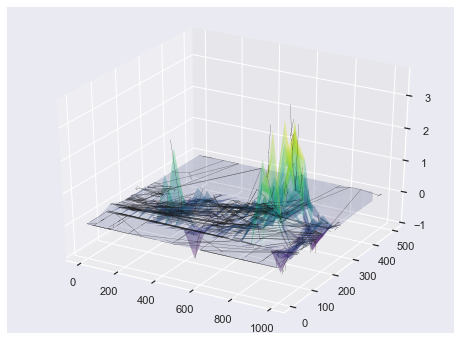

In [26]:
%matplotlib inline

num_pairs = node_connectivity.shape[0]
fig = plt.figure(figsize = (8,6))
ax = plt.axes(projection='3d')

for pair in range(num_pairs):
    pairID = node_connectivity[pair]
    pairID
    xdata, ydata, zdata = node_points[pairID, 0], node_points[pairID, 1], node_points[pairID, 2]

    ax.plot(xdata,ydata,zdata, 'k', linewidth=0.2)

step_size = 50
ax.plot_trisurf(surface_points[::step_size,0],surface_points[::step_size,1],surface_points[::step_size,2],cmap='viridis',edgecolor='none', alpha=0.2)
plt.show()


Load Nodes into graph

In [7]:
A = nx.Graph()
A.add_edges_from(node_connectivity)
# pos = graphviz_layout(A, prog='neato')

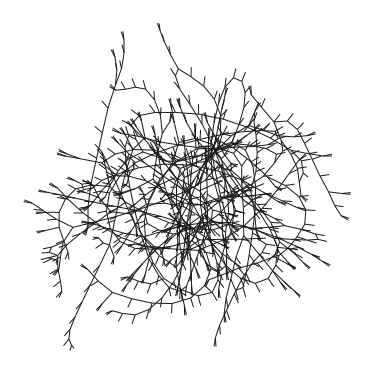

In [6]:
plt.figure(figsize=(5,5))
# nx.draw(A,pos,node_size=0)
nx.draw(A,node_size=0)

## Load group of skeletons into dictionary

In [4]:
file_prefix = 'input_strength032320'
skeleton_dir = 'D:/Jones_Lab/hnn_params/' + file_prefix + '/' +  file_prefix + '_skeleton'

# Remove suffix info, extract names
file_names = [f for f in listdir(skeleton_dir) if isfile(join(skeleton_dir, f))]
file_names = [f_new.replace('_arcs.csv','') for f_new in file_names]
file_names = [f_new.replace('_nodes.csv','') for f_new in file_names]
file_names = np.unique(file_names)


In [21]:
skeleton_dict = {}

for f in file_names:
    skeleton_dict[f] = {}

    df_path = skeleton_dir = 'D:/Jones_Lab/hnn_params/' + file_prefix + '/' +  file_prefix + '_skeleton/' + f + '_arcs.csv'
    connectivity_df = pd.read_csv(df_path, sep = ',')
    connectivity_map = np.array(connectivity_df[['upNodeId','downNodeId']])

    G = nx.Graph()
    G.add_edges_from(connectivity_map)

    skeleton_dict[f]['Network_obj'] = G.copy()
    skeleton_dict[f]['Diameter'] = nx.diameter(G) #Maximum eccentricity
    skeleton_dict[f]['Radius'] = nx.radius(G) #Minimum eccentricity
    skeleton_dict[f]['Num_nodes'] = nx.number_of_nodes(G)
    skeleton_dict[f]['Num_edges'] = nx.number_of_edges(G)
    skeleton_dict[f]['s_metric'] = nx.s_metric(G,normalized=False)

    # skeleton_dict[f]['Global_Efficiency'] = nx.global_efficiency(G)


    G.clear()
    print(f + '...done')


input_strength032320_sweep-numspikes_evprox_1_0_numspikes_evdist_1_0...done
input_strength032320_sweep-numspikes_evprox_1_0_numspikes_evdist_1_1...done
input_strength032320_sweep-numspikes_evprox_1_0_numspikes_evdist_1_2...done
input_strength032320_sweep-numspikes_evprox_1_1_numspikes_evdist_1_0...done
input_strength032320_sweep-numspikes_evprox_1_1_numspikes_evdist_1_1...done
input_strength032320_sweep-numspikes_evprox_1_1_numspikes_evdist_1_2...done
input_strength032320_sweep-numspikes_evprox_1_2_numspikes_evdist_1_0...done
input_strength032320_sweep-numspikes_evprox_1_2_numspikes_evdist_1_1...done
input_strength032320_sweep-numspikes_evprox_1_2_numspikes_evdist_1_2...done


### Plot graph radius and diameter

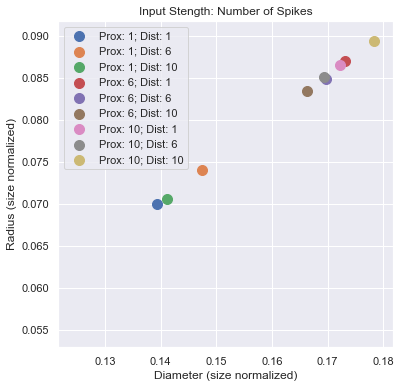

In [58]:
#Param values
param_names = ['Prox: ','; Dist: ']
param_val = [np.rint(np.linspace(1,10,3)).astype(int), np.rint(np.linspace(1,10,3)).astype(int)]
param_sets = [ [[s1,s2], [v1,v2]]  for s1,v1 in enumerate(param_val[0]) for s2,v2 in enumerate(param_val[1])]

legend_string = []
plt.figure(figsize=(6,6))
for idx,f in enumerate(file_names):
    # plt.subplot(3,3,idx+1)
    # vals = [skeleton_dict[f]['Diameter'], skeleton_dict[f]['Radius']]
    # vals = [skeleton_dict[f]['Diameter']]
    # plt.bar(np.arange(len(vals)),vals)

    f_label = param_names[0] + str(param_sets[idx][1][0]) + param_names[1] + str(param_sets[idx][1][1])
    legend_string.append(f_label)

    norm_list = [1, skeleton_dict[f]['Num_nodes'], skeleton_dict[f]['Num_edges']]
    norm_factor = norm_list[1]

    xval, yval = skeleton_dict[f]['Diameter'], skeleton_dict[f]['Radius']
    
    plt.scatter(xval/norm_factor, yval/norm_factor, s=100)

plt.legend(legend_string)
plt.xlabel('Diameter (size normalized)')
plt.ylabel('Radius (size normalized)')
plt.title('Input Stength: Number of Spikes')
plt.show()


### Computing graph-graph distance matrices

In [24]:
# z = nx.simrank_similarity_numpy(skeleton_dict[file_names[1]]['Network_obj'], skeleton_dict[file_names[6]]['Network_obj'])
# for i in z:
#     print(i)
# print(skeleton_dict[file_names[1]])

[nx.s_metric(skeleton_dict[f]['Network_obj'], normalized=False) for f in file_names]

[9043.0, 9897.0, 10087.0, 7964.0, 9363.0, 9686.0, 8087.0, 9606.0, 10075.0]

In [22]:
num_graphs = len(skeleton_dict)
distance_array = np.zeros((num_graphs,num_graphs))

# for r in np.arange(num_graphs):
#     for c in np.arange(num_graphs):
#         distance_array[r,c] = 


## Spectral Plot
Plotting based on coordinates of graph laplacian eigenvectors

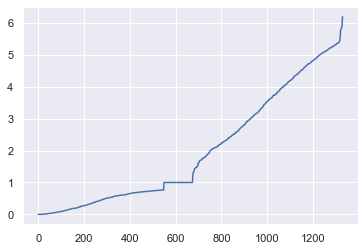

In [8]:
A_lambda = nx.laplacian_spectrum(A)
A_laplace = scipy.sparse.csr_matrix.toarray(nx.laplacian_matrix(A))

A_w, A_v = np.linalg.eig(A_laplace)     
A_v = np.real(A_v)
A_nodes = A.nodes
A_edges = A.edges


#Sort eigenvalues by magnitude
val_sort = A_w.argsort()[::]   
A_w = A_w[val_sort]
A_v = A_v[:,val_sort]

plt.plot(A_w)

In [10]:
critical_type_colors = ['green', 'yellow', 'gray', 'blue', 'red']
c_map = [critical_type_colors[node_color[c][0][0]] for c in node_color]

In [6]:
%matplotlib qt
v_idx = np.array([1,2,3]) + 0

x, y, z  = A_v[:,v_idx[0]], A_v[:,v_idx[1]], A_v[:,v_idx[2]]

fig = plt.figure(figsize = (13,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plt.axis('off')

ax.scatter(x,y,z, c=c_map)

for e in A_edges:
    x_pos = [x[e[0]], x[e[1]]]
    y_pos = [y[e[0]], y[e[1]]]
    z_pos = [z[e[0]], z[e[1]]]

    plt.plot(x_pos,y_pos,z_pos, 'k')

plt.title('Eigen Vector Projection')

ax = fig.add_subplot(1, 2, 2)
# ax.grid(False)
plt.plot(A_w)
plt.scatter(v_idx[0], A_w[v_idx[0]], color = 'red')
plt.title('Eigen Value Position')

plt.show()

In [11]:
%matplotlib inline

images = []
n_list = range(len(A_w))
for n in n_list :
    v_idx = np.array([1,2,3]) + n 

    x, y, z  = A_v[:,v_idx[0]], A_v[:,v_idx[1]], A_v[:,v_idx[2]]

    fig = plt.figure(figsize = (13,6))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    plt.axis('off')
    ax.scatter(x,y,z, c = c_map)

    # for e in A_edges:
    #     x_pos = [x[e[0]], x[e[1]]]
    #     y_pos = [y[e[0]], y[e[1]]]
    #     z_pos = [z[e[0]], z[e[1]]]

    #     plt.plot(x_pos,y_pos,z_pos, 'k')

    plt.title('Eigen Vector Projection')

    ax = fig.add_subplot(1, 2, 2)
    plt.plot(A_w)
    plt.scatter(v_idx[0], A_w[v_idx[0]], color = 'red')
    plt.title('Eigen Value Position')

    plt.savefig('D:/Jones_Lab/graph_spectrum_projection/eigen_val_' + str(n) + '.png')

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Jones_Lab/graph_sprectrum_projection/eigen_val_0.png'

In [79]:
A_lambda.shape

(1330,)

Turn into movie

In [17]:
import cv2
import os

image_folder = 'D:/Jones_Lab/gs2/'
video_name = 'tree_spectrum.avi'

images = []
n_list = range(0,len(A_w),33)
for n in n_list :
    images.append('eigen_val_' + str(n) + '.png')

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 10, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()